<a href="https://colab.research.google.com/github/CorrAUDJPY/Udacity-Project-2-Image-Classifer-with-Neural-Net/blob/main/Project2_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [4]:
# The new version of dataset is only available in the tfds-nightly package.
%pip --no cache-dir install tfds-nightly --user
!pip install tensorflow --upgrade --user

# DON'T MISS TO RESTART THE KERNEL


Usage:   
  pip3 <command> [options]

ambiguous option: --no (--no-cache-dir, --no-color, --no-input?)
     |████████████████████████████████| 320.4MB 53kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [6]:
# TODO: Make all other necessary imports
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
#import matplotlib as plt
import matplotlib.pyplot as plt
import pandas as pd
import json
import tensorflow as tf
import os

import datetime
import os
import sys

from PIL import Image
from google.colab import drive
import glob

import tensorflow_hub as hub
from tensorflow.keras import layers

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [ ]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102


In [8]:
# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()
#dataset,dataset_info=tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

(dataset, dataset_info) = tfds.load('oxford_flowers102', as_supervised=True, with_info=True,download=True)

In [9]:
# MOUNT THE GOOGLE DRIVE so that I can read and write on my Google Drive Space
drive.mount('/content/drive')
google_drive_path='/content/drive/My Drive/Colab Notebooks/'
project_folder_path='Udacity_Deep_Learning/'

Mounted at /content/drive


In [ ]:
dataset_info

In [11]:
# TODO: Create a training set, a validation set and a test set.
training_set=dataset['train']
validation_set=dataset['validation']
testing_set=dataset['test']


## Explore the Dataset

In [12]:
# TODO: Get the number of examples in each set from the dataset info.
train_examples=dataset_info.splits['train'].num_examples
validation_examples=dataset_info.splits['validation'].num_examples
test_examples=dataset_info.splits['test'].num_examples

# TODO: Get the number of classes in the dataset from the dataset info.
data_classes=dataset_info.features['label'].num_classes

print('Train Set: Num of examples ',train_examples)
print('Validation Set: Num of examples ',validation_examples)
print('Test Set: Num of examples ',test_examples)
print('Total Num of Features ',data_classes)

Train Set: Num of examples  1020
Validation Set: Num of examples  1020
Test Set: Num of examples  6149
Total Num of Features  102


In [13]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
i=1
for image,label in training_set.take(3):
  print('image {} has shape{} and label {}'.format(i, image.shape, label.numpy()))
  i+=1


image 1 has shape(500, 667, 3) and label 72
image 2 has shape(500, 666, 3) and label 84
image 3 has shape(670, 500, 3) and label 70


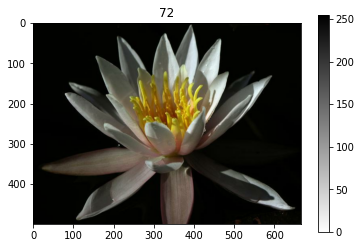

In [14]:
# TODO: Plot 1 image from the training set. 
for img,label in training_set.take(1):
  img=img.numpy().squeeze()
  label=label.numpy()

  plt.imshow(img,cmap=plt.cm.binary)
  plt.title(label)
  plt.colorbar()
# Set the title of the plot to the corresponding image label. 


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [180]:
#build the strings for the 4 images
fname=google_drive_path+project_folder_path+'label_map.json'

with open( fname, 'r') as f:
  class_names = json.load(f)

print(class_names)


{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

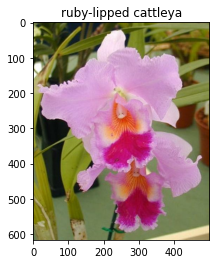

In [16]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for img,label in training_set.take(10):
  img=img.numpy().squeeze()
  label=str( label.numpy() +1)
  plt.imshow(img)
  plt.title( class_names[ label] )


## Create Pipeline

In [17]:
# TODO: Create a pipeline for each set.
def normalize(image,label) :
  image=tf.image.resize(image, (224,224))
  image=image/225
  return image,label

batch_size=32

training_batches=training_set.cache().shuffle( dataset_info.splits.total_num_examples//4).map(normalize).batch(batch_size).prefetch(1)
validation_batches=validation_set.cache().map(normalize).batch(batch_size).prefetch(1)
testing_batches=validation_set.cache().map(normalize).batch(batch_size).prefetch(1)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

The process below is heavily based on the 'Transfer Learning with TensorFlow Hub' described in Neural Nets Udacity Notebook 8.
We will follow the following steps:

*   define URL with the location of the mobilenet model
*   use hub.KerasLayer(URL , input_shape) to download the features
*   wrap it in a Keras layer (as input layer)
*  

Remember in MobileNET, ***image shape*** is (224,224,3)





In [18]:
URL= "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
image_dimensions=(224,224,3)

#extract the features from MOBILENET
feature_extractor=hub.KerasLayer(URL, input_shape=image_dimensions)
#ensure that weights and biases as read in from MOBILENET are not modified
feature_extractor.trainable=False


Next we build the model .....

In [19]:
numof_output_layer_nodes=len(class_names)

model=tf.keras.Sequential( [
                           feature_extractor,
                            tf.keras.layers.Dense(numof_output_layer_nodes,activation='softmax') ] )

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
# complie model
model.compile( optimizer='adam',  loss='sparse_categorical_crossentropy' , metrics=['accuracy'] ) 

#define early stopping rule
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy' , patience=5)

#n fit the model
EPOCHS=5

training_set_stats=model.fit( training_batches,
                    epochs=EPOCHS,
                  validation_data=validation_batches,
                  callbacks=[ early_stopping ]
                  )


Epoch 1/5
32/32 [==============================] - 67s 2s/step - loss: 4.2044 - accuracy: 0.1196 - val_loss: 2.9962 - val_accuracy: 0.4412
Epoch 2/5
32/32 [==============================] - 64s 2s/step - loss: 2.0085 - accuracy: 0.7127 - val_loss: 1.9597 - val_accuracy: 0.6588
Epoch 3/5
32/32 [==============================] - 64s 2s/step - loss: 1.0624 - accuracy: 0.9010 - val_loss: 1.4876 - val_accuracy: 0.7461
Epoch 4/5
32/32 [==============================] - 64s 2s/step - loss: 0.6429 - accuracy: 0.9608 - val_loss: 1.2519 - val_accuracy: 0.7667
Epoch 5/5
32/32 [==============================] - 64s 2s/step - loss: 0.4288 - accuracy: 0.9843 - val_loss: 1.1162 - val_accuracy: 0.7853


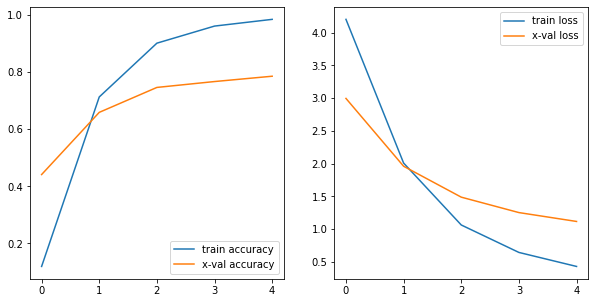

In [21]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy= training_set_stats.history['accuracy']
validation_accuracy= training_set_stats.history['val_accuracy']

training_loss= training_set_stats.history['loss']
validation_loss= training_set_stats.history['val_loss']

x=range(len(training_accuracy))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x,training_accuracy, label='train accuracy')
plt.plot(x,validation_accuracy,label='x-val accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(x,training_loss,label='train loss')
plt.plot(x,validation_loss, label='x-val loss')
plt.legend(loc='upper right')


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [22]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
test_loss,test_acc=model.evaluate( testing_batches )
print('Test Set Accuracy={}, Loss={}'.format( test_acc , test_loss ) )

32/32 [==============================] - 33s 1s/step - loss: 1.1162 - accuracy: 0.7853
Test Set Accuracy=0.7852941155433655, Loss=1.1162292957305908


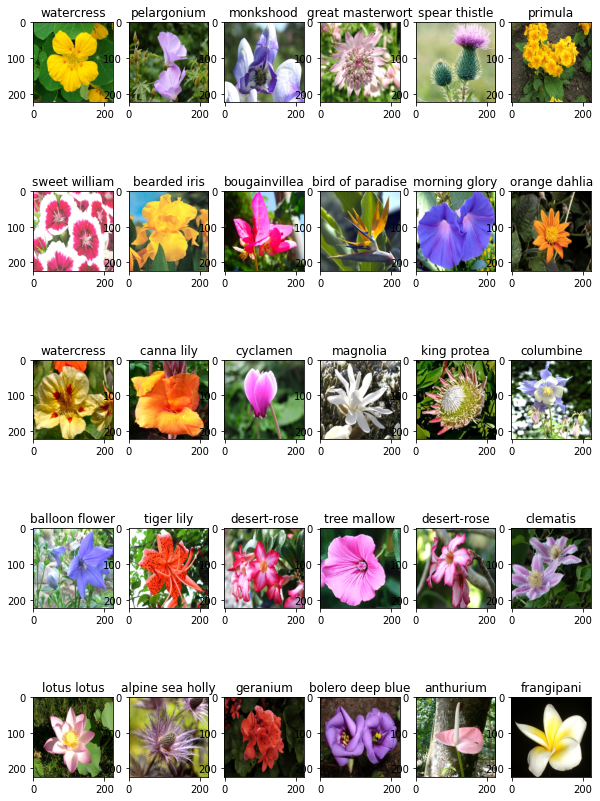

In [23]:
for image_batch, label_batch in testing_batches.take(1):
  ps=model.predict(image_batch)
  images=image_batch.numpy().squeeze()
  labels=label_batch.numpy()

plt.figure(figsize=(10,15) )
for i in range(30):
  plt.subplot(5,6,i+1)
  img=images[i]
  label=str(labels[i]+1 )
  name=class_names[label]

  plt.imshow( img ) 
  plt.title( name)

Therefore the testing set Accuracy was 80%

## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

The description of how to do this was found here:
https://www.tensorflow.org/guide/keras/save_and_serialize

In [24]:
# TODO: Save your trained model as a Keras model.
model_name=google_drive_path+project_folder_path + 'trained_flower_classif_model.h5'
model.save(model_name , save_format='HDF5')


## Load the Keras Model
Load the Keras model you saved above.

In [25]:
# TODO: Load the Keras model
trained_model=tf.keras.models.load_model( model_name, custom_objects={'KerasLayer':hub.KerasLayer} )

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [26]:
# TODO: Create the process_image function
def process_image(in_image):
  out_image=np.squeeze(in_image)
  out_image=tf.image.resize( out_image , (224,224) )
  out_image= out_image / 225
  return out_image


To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

Text(0.5, 1.0, 'processed image')

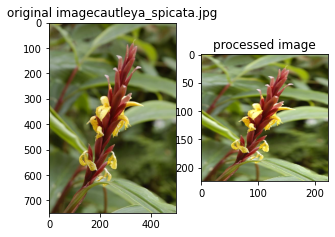

In [133]:
#build the strings for the 4 images
f1=google_drive_path+project_folder_path + 'cautleya_spicata.jpg'
f2=google_drive_path+project_folder_path + 'hard-leaved_pocked_orchid.jpg'
f3=google_drive_path+project_folder_path + 'orange_dahlia.jpg'
f4=google_drive_path+project_folder_path + 'wild_pansy.jpg'

# read and pre_process 'cautleya_spicata.jpg'
before_image=np.asarray( Image.open(f1) )
after_image=process_image(before_image)

fig , (ax1,ax2) = plt.subplots(figsize=(5,5) , ncols=2)
ax1.imshow(before_image)
ax2.imshow(after_image)
flower=f1.split('/')[-1]
ax1.set_title('original image'+flower)
ax2.set_title('processed image')


Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [183]:
# TODO: Create the predict function
def predict(image_path , model ,class_names , top_k):
  image_name = image_path.split('/')[-1][ : -4]
  print('Reading ....', image_name)
  # read and pre_process image
  im=Image.open(image_path) 
  im=np.array(im)
  im=process_image(im)
  im_final=np.expand_dims(im, axis=0)
  
  #run model.predict to get NN probabilities that image belongs in class j
  prob=model.predict(im_final)[0]
  
  #create dataframe with probability, class_id,class_name
  model_df=pd.DataFrame(prob)
  model_df.rename(columns = {0:'prob'}, inplace = True) 
  
  model_df['class']=model_df.index+1

  first_class_id=str( model_df['class'][0] )
  
  first_flower = class_names.get(first_class_id )
  
  model_df['name']=[ class_names.get(str(i)) for i in model_df['class'] ]
  
  
  model_df.sort_values(by='prob', ascending=False,inplace=True)
  
  return model_df['prob'].head(top_k) , model_df['class'].head(top_k), model_df['name'].head(top_k),im


Reading .... orange_dahlia


<BarContainer object of 5 artists>

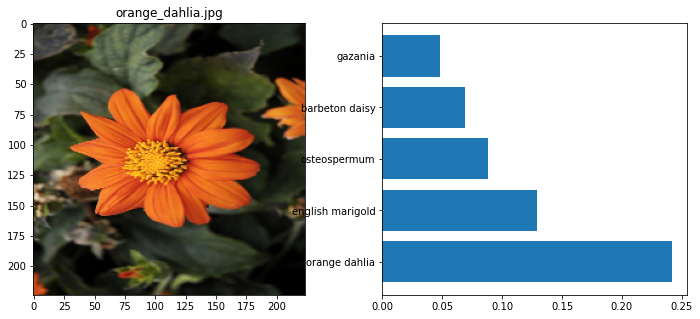

In [184]:
image_path=f3
model=trained_model
top_k=5

# returns a df with flower_name, probability and label
probs,classid,names,img=predict( image_path ,  model  , class_names, top_k )
fig,(ax1,ax2) = plt.subplots(figsize=(12,5),ncols=2)
ax1.imshow(img)
ax1.set_title(image_path.split('/')[-1])
x=np.arange( len(classid))
plt.barh(names,probs) 


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

Reading .... cautleya_spicata
Reading .... hard-leaved_pocket_orchid


Reading .... orange_dahlia
Reading .... wild_pansy


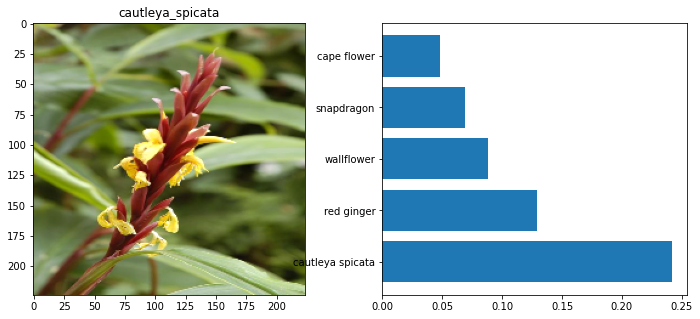

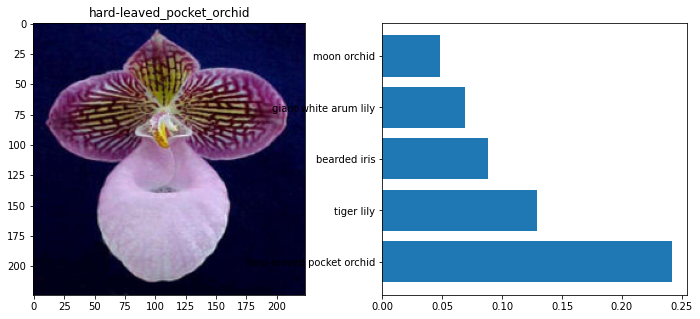

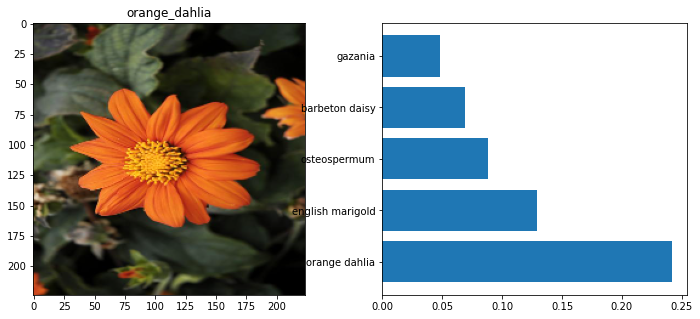

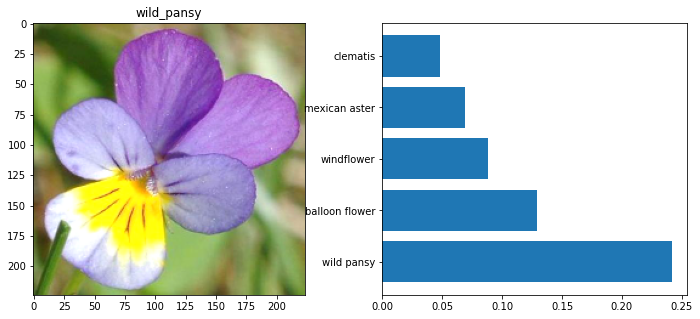

In [185]:
# TODO: Plot the input image along with the top 5 classes
#print(google_drive_path+project_folder_path+'*.jpg')
jpeg_files=glob.glob(google_drive_path+project_folder_path+'*.jpg')

for file in jpeg_files:
  flower_file=file.split('/')[-1]
  prob,classid,names,img=predict( file ,  trained_model  , class_names, 5 )

  fig,(ax1,ax2) = plt.subplots(figsize=(12,5),ncols=2)
  ax1.imshow(img)
  ax1.set_title(file.split('/')[-1][ : -4])
  x=np.arange( len(classid) )
  ax2.barh(names,probs) 
